In [1]:
############### Imports ###############
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
############### Data ###############
df1 = pd.read_csv("/Users/biancaorozco/Desktop/Metis/week02/project-02/airfare_project2/data/expedia_10_8_2019.csv")
df2 = pd.read_csv("/Users/biancaorozco/Desktop/Metis/week02/project-02/airfare_project2/data/expedia_10_9_2019.csv")
df3 = pd.read_csv("/Users/biancaorozco/Desktop/Metis/week02/project-02/airfare_project2/data/expedia_10_10_2019.csv")

frames = [df1, df2, df3]
na_df = pd.concat(frames)
print(na_df.shape)
na_df.sample(10, random_state=50)

(3183, 10)


/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,airline,arrival_airport,arrival_time,date,departure_airport,departure_time,duration,id_flight,number_stops,prices
638,Delta,Dallas DFW,5:30pm,10/8/19,San Francisco SFO,11:52pm,5h 6m,79.0,(1 stop),$362
804,American Airlines,Los Angeles LAX,6:00pm,10/9/2019,Atlanta ATL,2:24pm,6h 36m,15.0,(1 stop),$500
631,American Airlines,Los Angeles LAX,3:24pm,10/10/2019,Dallas DFW,10:40am,6h 44m,43.0,(1 stop),$297
216,Delta,Dallas DFW,6:17pm,10/8/19,Chicago ORD,1:05pm,5h 12m,61.0,(1 stop),$407
674,American Airlines,Chicago ORD,7:36pm,10/9/2019,Atlanta ATL,1:54pm,6h 42m,23.0,(1 stop),$291
470,United,Los Angeles LAX,11:59pm,10/9/2019,Denver DEN,8:39pm,2h 20m,2.0,(Nonstop),$414
651,Spirit Airlines,Chicago ORD,9:05pm,10/9/2019,Atlanta ATL,4:11pm,5h 54m,0.0,(1 stop),$216
940,Delta,Chicago ORD,9:44pm,10/8/19,Seattle SEA,2:25pm,5h 19m,75.0,(1 stop),$466
135,United,Dallas DFW,4:27pm,10/9/2019,Chicago ORD,9:20am,8h 7m,23.0,(1 stop),$408
621,American Airlines,Los Angeles LAX,9:26pm,10/10/2019,Dallas DFW,5:38pm,5h 48m,33.0,(1 stop),$297


In [3]:
############### Functions ###############
## Duration Time to Minutes
def duration_to_min(duration):
    time = duration.split()
    try:
        minutes = int(time[0])*60 + int(time[1])
        return minutes
    except:
        return None

## 12-hr Time to Minutes
def time_to_min(times):
    ztime = times.zfill(7)
    spaced_time = ztime[:5] + ' ' + ztime[5:]
    split = spaced_time.split()
    try:
        if split[2] == 'pm':
            minutes = (int(split[0])+12)*60 + int(split[1])
        else:
            minutes = int(split[0])*60 + int(split[1])
        return minutes
    except:
        return spaced_time

In [4]:
############### Cleaning Data ###############
## Dropping rows with NaNs
na_df.isna().sum()
df = na_df.dropna()
df.isna().sum()

airline              0
arrival_airport      0
arrival_time         0
date                 0
departure_airport    0
departure_time       0
duration             0
id_flight            0
number_stops         0
prices               0
dtype: int64

In [5]:
## Converting Flight ID to Integers
df['id_flight'] = pd.to_numeric(df.id_flight, downcast='signed')

## Removing $ and , from Prices and Convert to Numeric
df['prices'].replace('\$', value='', regex=True, inplace=True)
df['prices'].replace(',', value='', regex=True, inplace=True)
df['prices'] = pd.to_numeric(df.prices)

## Removing h & m from Duration Times
df['duration'].replace('h', value='', regex=True, inplace=True)
df['duration'].replace('m', value='', regex=True, inplace=True)

## Replacing : with _ in Departure and Arrival Times
df['departure_time'].replace(':', value=' ', regex=True, inplace=True)
df['arrival_time'].replace(':', value=' ', regex=True, inplace=True)

## Executing Cleaning Functions
df['departure_time'] = df['departure_time'].apply(time_to_min)
df['arrival_time'] = df['arrival_time'].apply(time_to_min)
df['duration'] = df['duration'].apply(duration_to_min)

/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

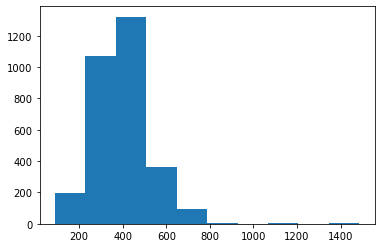

In [11]:
############### Features ###############
X = df.loc[:,['departure_time', 'arrival_time', 'airline', 'duration', 'number_stops', 'departure_airport', 'arrival_airport', 'date']]
y = df['prices']

## Prices are skewed left so take log to transform into a Gaussian Dist.
plt.hist(y);

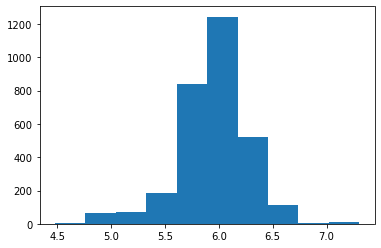

In [12]:
log_y = np.log(y)
plt.hist(log_y);

In [13]:
############### 2.Dummy Variables ###############
## Dummy Variables for Airlines, Departure Airport, Arrival Airport, and Date
print(X['airline'].nunique(), 'airlines') # 10 airlines
print(X['departure_airport'].nunique(), 'departure airports')
print(X['arrival_airport'].nunique(), 'arrival airports')
print(X['number_stops'].nunique(), 'number of stops\n')
X = pd.get_dummies(X)
X.info()

10 airlines
8 departure airports
7 arrival airports
4 number of stops

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3064 entries, 0 to 897
Data columns (total 35 columns):
departure_time                         3064 non-null int64
arrival_time                           3064 non-null int64
duration                               3064 non-null int64
airline_Alaska Airlines                3064 non-null uint8
airline_American Airlines              3064 non-null uint8
airline_Boutique Air                   3064 non-null uint8
airline_Delta                          3064 non-null uint8
airline_Frontier Airlines              3064 non-null uint8
airline_JetBlue Airways                3064 non-null uint8
airline_Multiple Airlines              3064 non-null uint8
airline_Spirit Airlines                3064 non-null uint8
airline_Sun Country Airlines           3064 non-null uint8
airline_United                         3064 non-null uint8
number_stops_(1 stop)                  3064 non-null uin

In [18]:
############### 3.Split Data ###############
## Splitting Train, Validate, Test Rows
X, X_test, log_y, y_test = train_test_split(X, log_y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X, log_y, test_size=.25, random_state=20)

In [19]:
############### 4.Scaling & Modeling ###############
# Model 1
lm = LinearRegression()

# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Model 2
lm_reg = Ridge(alpha=1)

# Feature Transform
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

# Model 3
lm_poly = LinearRegression()

In [20]:
############### 5.Choose Model ###############
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

## Choosing Linear Regression Model

Linear Regression val R^2: 0.433
Ridge Regression val R^2: 0.433
Degree 2 polynomial regression val R^2: -13482287.374


In [40]:
############### 6.Test ###############
lm.fit(X,log_y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.548


In [41]:
############### Predict ###############
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

In [46]:
############### Mean Absolute Error ###############
## Create Predicted y and Actual y Series with equal shape
y_pred = pd.DataFrame(np.exp(pred_test))
print(y_pred.shape)

## Randomly sample 613 observations from original dataset
y_actual = pd.DataFrame(y.sample(y_pred.shape[0], random_state=100))
print(y_actual.shape)

mean_absolute_error(y_actual, y_pred)
# On average, my model was off by approximately $

## Remember from EDA of Prices
# count    3064
# mean     $390.92
# std      $125.66
# min        $88
# 25%       $312
# 50%       $379
# 75%       $433
# max      $1486

(491, 1)
(491, 1)


116.73400070764573

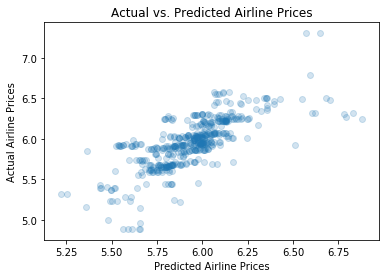

In [70]:
############### Actual vs Predicted ###############
plt.scatter(pred_test, y_test, alpha=.2)
# plt.plot(np.linspace(4,8,1), np.linspace(4,8,1))
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [73]:
y_pred = pd.DataFrame(np.exp(pred_test))
y_pred.shape

(491, 1)

count    3064.000000
mean      390.919060
std       125.656141
min        88.000000
25%       312.000000
50%       379.000000
75%       433.000000
max      1486.000000
Name: prices, dtype: float64


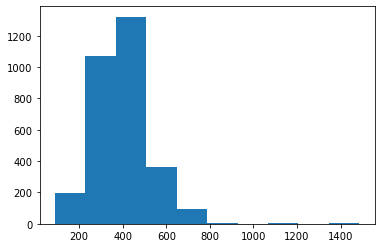

In [75]:
plt.hist(df['prices'])
print(df['prices'].describe())